Load best model artifacts + define categories/meta

In [12]:
import json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- load artifacts saved ---
model = joblib.load("artifacts/best_cluster_model.pkl")

with open("artifacts/feature_cols.json", "r") as f:
    feature_cols = json.load(f)

with open("artifacts/pipeline_config.json", "r") as f:
    PIPECFG = json.load(f)

# optional objects (may be None if didn't save them during training)
try:
    norm_obj = joblib.load("artifacts/norm_obj.pkl")
except Exception:
    norm_obj = None

try:
    outlier_bounds = joblib.load("artifacts/outlier_bounds.pkl")  # expected: {"lo":Series/dict, "hi":Series/dict}
except Exception:
    outlier_bounds = None

try:
    scaler_obj = joblib.load("artifacts/scaler_obj.pkl")
except Exception:
    scaler_obj = None

try:
    standardization_obj = joblib.load("artifacts/standardization_obj.pkl")
except Exception:
    standardization_obj = None

# --- 17 categories (must match training data schema) ---
INCOME_COL = "Income_Deposits"

CATEGORIES_17 = [
    "Income_Deposits",
    "Housing",
    "Utilities_Telecom",
    "Groceries_FoodAtHome",
    "Dining_FoodAway",
    "Transportation_Gas",
    "Transportation_PublicTransit",
    "Insurance_Health",
    "Insurance_Auto",
    "Medical_OutOfPocket",
    "Debt_Payments",
    "Savings_Investments",
    "Education_Childcare",
    "Entertainment",
    "Subscriptions_Memberships",
    "Pets",
    "Travel",
]

OUTFLOW_COLS = [c for c in CATEGORIES_17 if c != INCOME_COL]

CLUSTER_META = {
    0: {"name":"C1_low",        "range_yr":"<$28k",            "range_mo":"<$2.3k"},
    1: {"name":"C2_lower_mid",  "range_yr":"$28k–$50k",        "range_mo":"$2.3k–$4.2k"},
    2: {"name":"C3_mid",        "range_yr":"$50k–$75k",        "range_mo":"$4.2k–$6.2k"},
    3: {"name":"C4_upper_mid",  "range_yr":"$75k–$155k",       "range_mo":"$6.2k–$12.9k"},
    4: {"name":"C5_high",       "range_yr":"$155k–$210k",      "range_mo":"$12.9k–$17.5k"},
    5: {"name":"C6_top5",       "range_yr":">=$210k (top 5%)", "range_mo":">=$17.5k"},
}

def expected_cluster_by_income(monthly_income):
    if monthly_income < 2300: return 0
    if monthly_income < 4200: return 1
    if monthly_income < 6200: return 2
    if monthly_income < 12900: return 3
    if monthly_income < 17500: return 4
    return 5

print("Loaded model + artifacts.")
print("feature_cols:", len(feature_cols))
print("pipeline_config:", PIPECFG)

Loaded model + artifacts.
feature_cols: 37
pipeline_config: {'norm_method': 'sqrt', 'reg_mode': 'l2', 'reg_params': {'C': 1.0}, 'outlier_method': 'none', 'feature_select_method': 'heatmap_drop', 'scaler_method': 'robust', 'standardization_method': 'none', 'sampling_method': 'SMOTE'}


Inference transforms + feature builders (one month + multi-month)

In [13]:
def _apply_norm_df(Xdf: pd.DataFrame, method: str):
    if method in (None, "none"):
        return Xdf

    X = Xdf.copy()

    if method == "log":
        return np.log1p(np.clip(X, 0, None))

    if method == "inverse":
        eps = 1e-3
        return 1.0 / (np.clip(X, 0, None) + eps)

    if method == "sqrt":
        return np.sqrt(np.clip(X, 0, None))

    if method == "square":
        return np.square(X)

    if method == "zscore":
        # NOTE: "zscore" in training was fitted; if used zscore here, MUST have scaler_obj instead.
        # Treat this as "do nothing" because proper zscore needs fitted mean/std.
        print("[WARN] norm_method=zscore requires fitted stats; skipping here. Prefer scaler_obj stage.")
        return X

    if method in ("yeo_johnson", "quantile_normal"):
        if norm_obj is None:
            raise RuntimeError(f"norm_method={method} but artifacts/norm_obj.pkl is missing. Save it during training.")
        Xt = norm_obj.transform(X.values)
        return pd.DataFrame(Xt, columns=X.columns, index=X.index)

    raise ValueError(f"Unknown norm_method: {method}")

def _apply_outlier_clip_df(Xdf: pd.DataFrame, outlier_method: str):
    if outlier_method in (None, "none"):
        return Xdf

    if outlier_bounds is None:
        print("[WARN] outlier_method set but artifacts/outlier_bounds.pkl missing; skipping clipping.")
        return Xdf

    lo = outlier_bounds.get("lo", None)
    hi = outlier_bounds.get("hi", None)
    if lo is None or hi is None:
        print("[WARN] outlier_bounds missing lo/hi; skipping clipping.")
        return Xdf

    # allow dict/Series
    lo_s = pd.Series(lo)
    hi_s = pd.Series(hi)

    # clip only columns that exist in bounds
    Xc = Xdf.copy()
    common = [c for c in Xc.columns if c in lo_s.index and c in hi_s.index]
    if not common:
        return Xc
    return Xc.clip(lower=lo_s[common], upper=hi_s[common], axis=1)

def apply_inference_pipeline(feats: pd.DataFrame) -> pd.DataFrame:
    """
    Apply the SAME preprocessing choices used at training time (as much as possible from saved artifacts).
    Expects feats already aligned to `feature_cols` (final selected features).
    """
    X = feats.copy()

    # normalization (if used) — may require norm_obj
    X = _apply_norm_df(X, PIPECFG.get("norm_method"))

    # outlier clipping (if used) — requires outlier_bounds
    X = _apply_outlier_clip_df(X, PIPECFG.get("outlier_method"))

    # scaling (if used) — uses fitted scaler_obj
    if PIPECFG.get("scaler_method") not in (None, "none"):
        if scaler_obj is None:
            raise RuntimeError("scaler_method is set but artifacts/scaler_obj.pkl is missing.")
        X = pd.DataFrame(scaler_obj.transform(X.values), columns=X.columns, index=X.index)

    # row-wise normalization (if used) — uses fitted normalizer
    if PIPECFG.get("standardization_method") not in (None, "none"):
        if standardization_obj is None:
            raise RuntimeError("standardization_method is set but artifacts/standardization_obj.pkl is missing.")
        X = pd.DataFrame(standardization_obj.transform(X.values), columns=X.columns, index=X.index)

    return X

def month_dict_to_base_features(m: dict) -> dict:
    income = float(m[INCOME_COL])
    if income <= 0:
        raise ValueError("Income must be > 0")

    base = {}
    for c in OUTFLOW_COLS:
        base[f"{c}__share"] = float(m.get(c, 0.0)) / income

    total_out = sum(float(m.get(c, 0.0)) for c in OUTFLOW_COLS)
    net = income - total_out

    base["NetCashflowRate"] = net / income
    base["EssentialRate"] = (float(m.get("Housing",0.0)) +
                             float(m.get("Utilities_Telecom",0.0)) +
                             float(m.get("Groceries_FoodAtHome",0.0))) / income
    base["DebtRate"] = float(m.get("Debt_Payments",0.0)) / income
    base["SavingsRate"] = float(m.get("Savings_Investments",0.0)) / income
    base["DiscretionaryRate"] = (float(m.get("Dining_FoodAway",0.0)) +
                                 float(m.get("Entertainment",0.0)) +
                                 float(m.get("Travel",0.0)) +
                                 float(m.get("Subscriptions_Memberships",0.0))) / income
    return base

def months_to_features(months: list[dict]) -> pd.DataFrame:
    """
    Build the same person-level aggregate features you trained on:
    base monthly (shares + rates) -> mean/median/std
    """
    B = pd.DataFrame([month_dict_to_base_features(m) for m in months])

    agg = {}
    for c in B.columns:
        agg[f"{c}__mean"] = float(B[c].mean())
        agg[f"{c}__median"] = float(B[c].median())
        agg[f"{c}__std"] = float(B[c].std(ddof=0))

    feats = pd.DataFrame([agg])

    # align to final selected feature list
    for c in feature_cols:
        if c not in feats.columns:
            feats[c] = 0.0
    feats = feats[feature_cols]

    # apply inference transforms
    feats = apply_inference_pipeline(feats)
    return feats

def month_to_feature_row(month_dollars: dict) -> pd.DataFrame:
    """
    One-month "proxy person" features:
    mean=median=value, std ~ 0 (we keep tiny eps to avoid pathological zeros if you want)
    """
    row = {c: float(month_dollars.get(c, 0.0)) for c in CATEGORIES_17}
    df = pd.DataFrame([row])

    income = float(df[INCOME_COL].values[0])
    if income <= 0:
        raise ValueError("Income must be > 0 for shares/rates")

    # base monthly features
    base = {}
    for c in OUTFLOW_COLS:
        base[f"{c}__share"] = float(df[c].values[0]) / income

    total_out = float(df[OUTFLOW_COLS].sum(axis=1).values[0])
    net = income - total_out

    base["NetCashflowRate"] = net / income
    base["EssentialRate"] = float(df[["Housing","Utilities_Telecom","Groceries_FoodAtHome"]].sum(axis=1).values[0]) / income
    base["DebtRate"] = float(df["Debt_Payments"].values[0]) / income
    base["SavingsRate"] = float(df["Savings_Investments"].values[0]) / income
    base["DiscretionaryRate"] = float(df[["Dining_FoodAway","Entertainment","Travel","Subscriptions_Memberships"]].sum(axis=1).values[0]) / income

    # aggregate proxy
    eps_std = 0.0  # keep 0.0 to match your earlier intent; if needed, change to 1e-6
    agg = {}
    for k, v in base.items():
        agg[f"{k}__mean"] = float(v)
        agg[f"{k}__median"] = float(v)
        agg[f"{k}__std"] = float(eps_std)

    feats = pd.DataFrame([agg])

    # align to final selected feature list
    for c in feature_cols:
        if c not in feats.columns:
            feats[c] = 0.0
    feats = feats[feature_cols]

    # apply inference transforms
    feats = apply_inference_pipeline(feats)
    return feats

def proba_dict(proba):
    return {f"p_{CLUSTER_META[j]['name']}": float(proba[j]) for j in range(len(proba))}

def pretty_predict_one_month(month_dollars: dict):
    X = month_to_feature_row(month_dollars)
    proba = model.predict_proba(X.values)[0]
    pred = int(np.argmax(proba))

    print(f"Predicted cluster: {pred} | {CLUSTER_META[pred]['name']} | income ~ {CLUSTER_META[pred]['range_yr']} ({CLUSTER_META[pred]['range_mo']}/mo)")
    print("Probabilities:")
    for i, p in enumerate(proba * 100):
        print(f"  {i} {CLUSTER_META[i]['name']:<12} : {p:10.6f}%")
    return pred, proba

One-month test + 6-month behavior timeline test

Expected by income: 2 | C3_mid | $50k–$75k ($4.2k–$6.2k/mo)

Predicted cluster: 1 | C2_lower_mid | income ~ $28k–$50k ($2.3k–$4.2k/mo)
Probabilities:
  0 C1_low       :   0.192774%
  1 C2_lower_mid :  81.103020%
  2 C3_mid       :   1.424864%
  3 C4_upper_mid :   5.603523%
  4 C5_high      :   0.808951%
  5 C6_top5      :  10.866864%

--- Another extreme month ---

Expected by income: 5 | C6_top5 | >=$210k (top 5%) (>=$17.5k/mo)

Predicted cluster: 5 | C6_top5 | income ~ >=$210k (top 5%) (>=$17.5k/mo)
Probabilities:
  0 C1_low       :   0.003785%
  1 C2_lower_mid :   0.000107%
  2 C3_mid       :   0.000538%
  3 C4_upper_mid :   0.001516%
  4 C5_high      :   0.003300%
  5 C6_top5      :  99.990753%
Predicted cluster: 1 | C2_lower_mid | income ~ $28k–$50k ($2.3k–$4.2k/mo)
Probabilities:
  0 C1_low       :   0.192774%
  1 C2_lower_mid :  81.103020%
  2 C3_mid       :   1.424864%
  3 C4_upper_mid :   5.603523%
  4 C5_high      :   0.808951%
  5 C6_top5      :  10.866864%
Predicted cluster

,month,SavingsRate,NetCashflowRate,pred_single_month,top_prob_%,p_C1_low,p_C2_lower_mid,p_C3_mid,p_C4_upper_mid,p_C5_high,p_C6_top5
0,1,0.133333,0.143333,C2_lower_mid,81.103020,0.001928,0.811030,0.014249,0.056035,0.008090,0.108669
1,2,0.150000,0.131667,C2_lower_mid,81.552383,0.002057,0.815524,0.013991,0.056058,0.008216,0.104154
2,3,0.166667,0.120000,C2_lower_mid,81.916595,0.002104,0.819166,0.013936,0.055986,0.008447,0.100361
3,4,0.183333,0.108333,C2_lower_mid,81.526527,0.002661,0.815265,0.013253,0.061350,0.008343,0.099128
4,5,0.200000,0.096667,C2_lower_mid,82.131279,0.004506,0.821313,0.013425,0.048137,0.008577,0.104041
5,6,0.216667,0.085000,C2_lower_mid,82.481873,0.005593,0.824819,0.010473,0.047646,0.008490,0.102980



Table 2 — Timeline prediction (cumulative months 1..t):



,months_used,pred_index,pred_name,top_prob_%,p_C1_low,p_C2_lower_mid,p_C3_mid,p_C4_upper_mid,p_C5_high,p_C6_top5
0,1,1,C2_lower_mid,81.103020,0.001928,0.811030,0.014249,0.056035,0.008090,0.108669
1,2,1,C2_lower_mid,81.433777,0.002054,0.814338,0.013971,0.055976,0.008092,0.105569
2,3,1,C2_lower_mid,81.552383,0.002057,0.815524,0.013991,0.056058,0.008216,0.104154
3,4,1,C2_lower_mid,82.005539,0.002031,0.820055,0.014038,0.055360,0.008268,0.100247
4,5,1,C2_lower_mid,81.916595,0.002104,0.819166,0.013936,0.055986,0.008447,0.100361
5,6,1,C2_lower_mid,81.541512,0.002217,0.815415,0.013516,0.061361,0.008344,0.099146



Plot — Predicted probabilities in log scale:



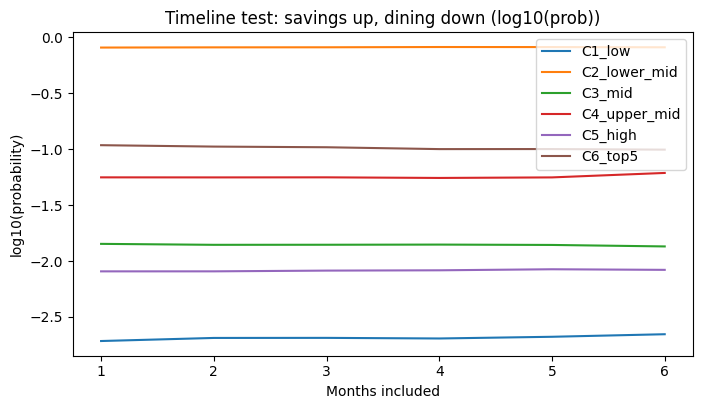

In [14]:
example_month = {
    "Income_Deposits": 6000,
    "Housing": 1800,
    "Utilities_Telecom": 250,
    "Groceries_FoodAtHome": 500,
    "Dining_FoodAway": 300,
    "Transportation_Gas": 200,
    "Transportation_PublicTransit": 0,
    "Insurance_Health": 200,
    "Insurance_Auto": 150,
    "Medical_OutOfPocket": 50,
    "Debt_Payments": 400,
    "Savings_Investments": 800,
    "Education_Childcare": 0,
    "Entertainment": 150,
    "Subscriptions_Memberships": 60,
    "Pets": 80,
    "Travel": 200,
}

example_month_2 = {
    "Income_Deposits": 490608.89,
    "Housing": 4960.89,
    "Utilities_Telecom": 3019.81,
    "Groceries_FoodAtHome": 496.09,
    "Dining_FoodAway": 1488.27,
    "Transportation_Gas": 224.53,
    "Transportation_PublicTransit": 19.82,
    "Insurance_Health": 779.54,
    "Insurance_Auto": 2893.02,
    "Medical_OutOfPocket": 9539.58,
    "Debt_Payments": 903.37,
    "Savings_Investments": 1936.71,
    "Education_Childcare": 452.55,
    "Entertainment": 1362.01,
    "Subscriptions_Memberships": 512.48,
    "Pets": 800,
    "Travel": 55.95,
}

exp_idx = expected_cluster_by_income(example_month["Income_Deposits"])
print(f"Expected by income: {exp_idx} | {CLUSTER_META[exp_idx]['name']} | {CLUSTER_META[exp_idx]['range_yr']} ({CLUSTER_META[exp_idx]['range_mo']}/mo)\n")
pretty_predict_one_month(example_month)

print("\n--- Another extreme month ---\n")
exp2 = expected_cluster_by_income(example_month_2["Income_Deposits"])
print(f"Expected by income: {exp2} | {CLUSTER_META[exp2]['name']} | {CLUSTER_META[exp2]['range_yr']} ({CLUSTER_META[exp2]['range_mo']}/mo)\n")
pretty_predict_one_month(example_month_2)

# ---- 6-month "behavior change" timeline test ----
def month_rates(m):
    inc = float(m[INCOME_COL])
    out = sum(float(m.get(c,0.0)) for c in OUTFLOW_COLS)
    return {
        "Income": inc,
        "SavingsRate": float(m.get("Savings_Investments",0.0))/inc,
        "DebtRate": float(m.get("Debt_Payments",0.0))/inc,
        "EssentialRate": (float(m.get("Housing",0.0))+float(m.get("Utilities_Telecom",0.0))+float(m.get("Groceries_FoodAtHome",0.0)))/inc,
        "DiscretionaryRate": (float(m.get("Dining_FoodAway",0.0))+float(m.get("Entertainment",0.0))+float(m.get("Travel",0.0))+float(m.get("Subscriptions_Memberships",0.0)))/inc,
        "NetCashflowRate": (inc - out)/inc,
    }

def run_trajectory(months: list[dict], title="Trajectory"):
    rows = []
    probas = []

    for t in range(1, len(months)+1):
        Xt = months_to_features(months[:t])
        proba = model.predict_proba(Xt.values)[0]
        pred = int(np.argmax(proba))
        probas.append(proba)

        row = {
            "months_used": t,
            "pred_index": pred,
            "pred_name": CLUSTER_META[pred]["name"],
            "top_prob_%": float(np.max(proba) * 100.0),
        }
        row.update(proba_dict(proba))
        rows.append(row)

    print("\nTable 2 — Timeline prediction (cumulative months 1..t):\n")
    df_out = pd.DataFrame(rows)
    display(df_out)

    # Plot — Predicted probabilities in log scale
    P = np.array(probas)
    x = np.arange(1, P.shape[0]+1)

    print("\nPlot — Predicted probabilities in log scale:\n")
    eps = 1e-12
    plt.figure(figsize=(8, 4.2))
    for i in range(P.shape[1]):
        plt.plot(x, np.log10(P[:, i] + eps), label=CLUSTER_META[i]["name"])
    plt.title(title + " (log10(prob))")
    plt.xlabel("Months included")
    plt.ylabel("log10(probability)")
    plt.legend()
    plt.show()

# hardcoded months for behavior test
month1 = dict(example_month)

month2 = dict(example_month); month2["Savings_Investments"] = 900;  month2["Dining_FoodAway"] = 270
month3 = dict(example_month); month3["Savings_Investments"] = 1000; month3["Dining_FoodAway"] = 240
month4 = dict(example_month); month4["Savings_Investments"] = 1100; month4["Dining_FoodAway"] = 210
month5 = dict(example_month); month5["Savings_Investments"] = 1200; month5["Dining_FoodAway"] = 180
month6 = dict(example_month); month6["Savings_Investments"] = 1300; month6["Dining_FoodAway"] = 150

months_demo = [month1, month2, month3, month4, month5, month6]

rows = []
for i, m in enumerate(months_demo, 1):
    pred1, proba1 = pretty_predict_one_month(m)
    rates = month_rates(m)
    row = {
        "month": i,
        "SavingsRate": rates["SavingsRate"],
        "NetCashflowRate": rates["NetCashflowRate"],
        "pred_single_month": CLUSTER_META[pred1]["name"],
        "top_prob_%": float(np.max(proba1)*100),
    }
    row.update(proba_dict(proba1))
    rows.append(row)

print("\nTable 1 — Single-month prediction + rates:\n")
display(pd.DataFrame(rows))

run_trajectory(months_demo, title="Timeline test: savings up, dining down")

48-month what-if transition C1 -> C4 (heuristic + tables + radar + plots)


Searching anchor C1->0 (income=2200, max_tries=2500)


Searching anchor C1->0:   0%|          | 0/2500 [00:00<?, ?it/s]

[FOUND] C1->0 at try=0 | top_p=1.0000 | p_target=1.0000

Searching anchor C4->3 (income=9000, max_tries=2500)


Searching anchor C4->3:   0%|          | 0/2500 [00:00<?, ?it/s]

[FOUND] C4->3 at try=1968 | top_p=0.9822 | p_target=0.9822

Expectation:

Expected (intent): start=C1_low -> target=C4_upper_mid
Expected by income (month 1):  C1_low
Expected by income (month 48): C4_upper_mid

Anchors found (single-month view for month 1 of each anchor):

Predicted cluster: 0 | C1_low | income ~ <$28k (<$2.3k/mo)
Probabilities:
  0 C1_low       :  99.999809%
  1 C2_lower_mid :   0.000068%
  2 C3_mid       :   0.000002%
  3 C4_upper_mid :   0.000042%
  4 C5_high      :   0.000006%
  5 C6_top5      :   0.000077%
Predicted cluster: 3 | C4_upper_mid | income ~ $75k–$155k ($6.2k–$12.9k/mo)
Probabilities:
  0 C1_low       :   0.044454%
  1 C2_lower_mid :   0.036840%
  2 C3_mid       :  23.354239%
  3 C4_upper_mid :  76.213989%
  4 C5_high      :   0.050367%
  5 C6_top5      :   0.300115%

Table 0 — Dollar amounts per month (all categories):



,month,Income_Deposits,Housing,Utilities_Telecom,Groceries_FoodAtHome,Dining_FoodAway,Transportation_Gas,Transportation_PublicTransit,Insurance_Health,Insurance_Auto,Medical_OutOfPocket,Debt_Payments,Savings_Investments,Education_Childcare,Entertainment,Subscriptions_Memberships,Pets,Travel
0,1,2200.000000,746.85,128.51,227.71,60.13,43.61,55.19,58.47,62.63,50.36,233.80,61.23,54.46,20.07,11.36,53.16,12.95
1,2,2344.680851,779.72,126.37,243.55,67.91,48.02,57.58,66.65,65.22,51.77,226.27,103.21,58.33,24.68,13.81,64.55,18.78
2,3,2489.361702,767.79,125.89,254.57,81.60,52.93,59.62,66.54,71.13,57.09,227.52,141.97,61.69,29.17,16.24,71.78,26.04
3,4,2634.042553,811.40,132.82,259.19,93.39,53.30,63.97,68.17,71.23,58.76,237.25,182.25,67.77,30.25,18.18,75.85,34.53
4,5,2778.723404,851.23,145.36,252.21,98.52,62.29,68.81,66.27,69.17,57.93,228.60,239.04,72.40,34.20,20.73,81.82,41.11
5,6,2923.404255,877.25,144.93,246.19,104.70,63.24,76.99,68.72,72.99,62.81,217.57,309.22,73.55,38.32,23.04,76.14,44.56
6,7,3068.085106,807.34,142.23,252.30,107.47,68.11,89.13,71.84,80.14,62.02,197.47,346.99,73.66,45.77,22.84,82.23,53.53
7,8,3212.765957,788.90,136.88,253.04,113.48,75.76,93.99,84.10,82.21,61.42,183.52,415.10,81.74,53.15,26.17,93.46,57.11
8,9,3357.446809,774.52,138.40,247.14,113.39,85.17,97.36,80.02,80.46,66.69,177.51,533.96,97.22,58.91,27.08,83.70,66.58
9,10,3502.127660,758.68,145.51,239.77,123.86,96.54,103.21,84.20,79.57,63.35,158.37,583.15,106.11,63.36,31.66,85.78,69.14



Table 0b — Dollar change per month (Δ$ for all categories):



,month,Income_Deposits,Housing,Utilities_Telecom,Groceries_FoodAtHome,Dining_FoodAway,Transportation_Gas,Transportation_PublicTransit,Insurance_Health,Insurance_Auto,Medical_OutOfPocket,Debt_Payments,Savings_Investments,Education_Childcare,Entertainment,Subscriptions_Memberships,Pets,Travel
0,1,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2,144.680851,32.87,-2.14,15.84,7.78,4.41,2.39,8.18,2.59,1.41,-7.53,41.98,3.87,4.61,2.45,11.39,5.83
2,3,144.680851,-11.93,-0.48,11.02,13.69,4.91,2.04,-0.11,5.91,5.32,1.25,38.76,3.36,4.49,2.43,7.23,7.26
3,4,144.680851,43.61,6.93,4.62,11.79,0.37,4.35,1.63,0.10,1.67,9.73,40.28,6.08,1.08,1.94,4.07,8.49
4,5,144.680851,39.83,12.54,-6.98,5.13,8.99,4.84,-1.90,-2.06,-0.83,-8.65,56.79,4.63,3.95,2.55,5.97,6.58
5,6,144.680851,26.02,-0.43,-6.02,6.18,0.95,8.18,2.45,3.82,4.88,-11.03,70.18,1.15,4.12,2.31,-5.68,3.45
6,7,144.680851,-69.91,-2.70,6.11,2.77,4.87,12.14,3.12,7.15,-0.79,-20.10,37.77,0.11,7.45,-0.20,6.09,8.97
7,8,144.680851,-18.44,-5.35,0.74,6.01,7.65,4.86,12.26,2.07,-0.60,-13.95,68.11,8.08,7.38,3.33,11.23,3.58
8,9,144.680851,-14.38,1.52,-5.90,-0.09,9.41,3.37,-4.08,-1.75,5.27,-6.01,118.86,15.48,5.76,0.91,-9.76,9.47
9,10,144.680851,-15.84,7.11,-7.37,10.47,11.37,5.85,4.18,-0.89,-3.34,-19.14,49.19,8.89,4.45,4.58,2.08,2.56


Single-month predictions:   0%|          | 0/48 [00:00<?, ?it/s]

Predicted cluster: 0 | C1_low | income ~ <$28k (<$2.3k/mo)
Probabilities:
  0 C1_low       :  99.999725%
  1 C2_lower_mid :   0.000111%
  2 C3_mid       :   0.000004%
  3 C4_upper_mid :   0.000039%
  4 C5_high      :   0.000013%
  5 C6_top5      :   0.000113%
Predicted cluster: 0 | C1_low | income ~ <$28k (<$2.3k/mo)
Probabilities:
  0 C1_low       :  99.999252%
  1 C2_lower_mid :   0.000377%
  2 C3_mid       :   0.000014%
  3 C4_upper_mid :   0.000091%
  4 C5_high      :   0.000025%
  5 C6_top5      :   0.000247%
Predicted cluster: 0 | C1_low | income ~ <$28k (<$2.3k/mo)
Probabilities:
  0 C1_low       :  99.997482%
  1 C2_lower_mid :   0.001349%
  2 C3_mid       :   0.000035%
  3 C4_upper_mid :   0.000201%
  4 C5_high      :   0.000048%
  5 C6_top5      :   0.000887%
Predicted cluster: 0 | C1_low | income ~ <$28k (<$2.3k/mo)
Probabilities:
  0 C1_low       :  99.995895%
  1 C2_lower_mid :   0.001769%
  2 C3_mid       :   0.000044%
  3 C4_upper_mid :   0.000362%
  4 C5_high      :   0

,month,Income,SavingsRate,NetCashflowRate,pred_single_month,top_prob_%,p_C1_low,p_C2_lower_mid,p_C3_mid,p_C4_upper_mid,p_C5_high,p_C6_top5
0,1,2200.000000,0.027832,0.145232,C1_low,99.999725,0.999997,0.000001,4.092342e-08,3.941707e-07,1.271088e-07,0.000001
1,2,2344.680851,0.044019,0.140002,C1_low,99.999252,0.999992,0.000004,1.420010e-07,9.095235e-07,2.489543e-07,0.000002
2,3,2489.361702,0.057031,0.151762,C1_low,99.997482,0.999975,0.000013,3.523042e-07,2.014896e-06,4.771761e-07,0.000009
3,4,2634.042553,0.069190,0.142645,C1_low,99.995895,0.999959,0.000018,4.445257e-07,3.618937e-06,6.489102e-07,0.000019
4,5,2778.723404,0.086025,0.140004,C1_low,99.968781,0.999688,0.000210,1.639147e-06,2.145291e-05,2.598144e-06,0.000077
5,6,2923.404255,0.105774,0.144757,C2_lower_mid,93.629128,0.009758,0.936291,8.964947e-04,1.010158e-02,1.136524e-03,0.041816
6,7,3068.085106,0.113097,0.184159,C2_lower_mid,56.200630,0.004873,0.562006,5.859560e-04,5.875377e-03,7.105547e-04,0.425948
7,8,3212.765957,0.129203,0.190719,C6_top5,58.376335,0.003214,0.407778,4.412732e-04,4.320757e-03,4.829733e-04,0.583763
8,9,3357.446809,0.159038,0.187445,C6_top5,55.238724,0.003107,0.436286,8.647261e-04,6.789802e-03,5.650136e-04,0.552387
9,10,3502.127660,0.166513,0.202696,C6_top5,65.635735,0.001428,0.331865,4.205232e-03,5.699193e-03,4.446522e-04,0.656357



Table 2 — Timeline prediction (cumulative months 1..t):



,months_used,pred_index,pred_name,top_prob_%,p_C1_low,p_C2_lower_mid,p_C3_mid,p_C4_upper_mid,p_C5_high,p_C6_top5
0,1,0,C1_low,99.999725,0.999997,0.000001,4.092342e-08,3.941707e-07,1.271088e-07,0.000001
1,2,0,C1_low,99.999664,0.999997,0.000001,6.217121e-08,4.798237e-07,1.332380e-07,0.000001
2,3,0,C1_low,99.999214,0.999992,0.000004,1.394780e-07,9.250813e-07,2.528542e-07,0.000003
3,4,0,C1_low,99.998451,0.999985,0.000008,2.043173e-07,1.338600e-06,3.383550e-07,0.000006
4,5,0,C1_low,99.997581,0.999976,0.000013,3.434654e-07,1.942256e-06,4.652048e-07,0.000009
5,6,0,C1_low,99.996819,0.999968,0.000018,4.129757e-07,2.646181e-06,5.965731e-07,0.000010
6,7,0,C1_low,99.997177,0.999972,0.000012,2.951482e-07,2.354526e-06,4.320030e-07,0.000014
7,8,0,C1_low,99.994911,0.999949,0.000027,3.315888e-07,3.856781e-06,5.712722e-07,0.000019
8,9,0,C1_low,99.981133,0.999811,0.000117,1.048780e-06,9.215564e-06,1.502106e-06,0.000060
9,10,0,C1_low,99.198090,0.991981,0.005710,2.704290e-05,1.533547e-04,2.777028e-05,0.002101



Plot — Predicted probabilities in log scale:



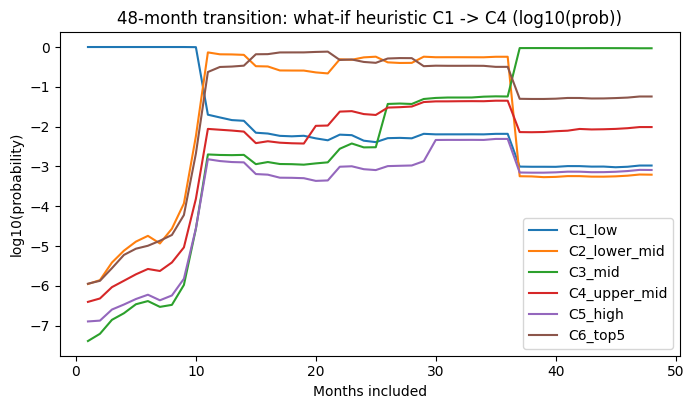


Plot — Radar chart (probabilities every 12 months):



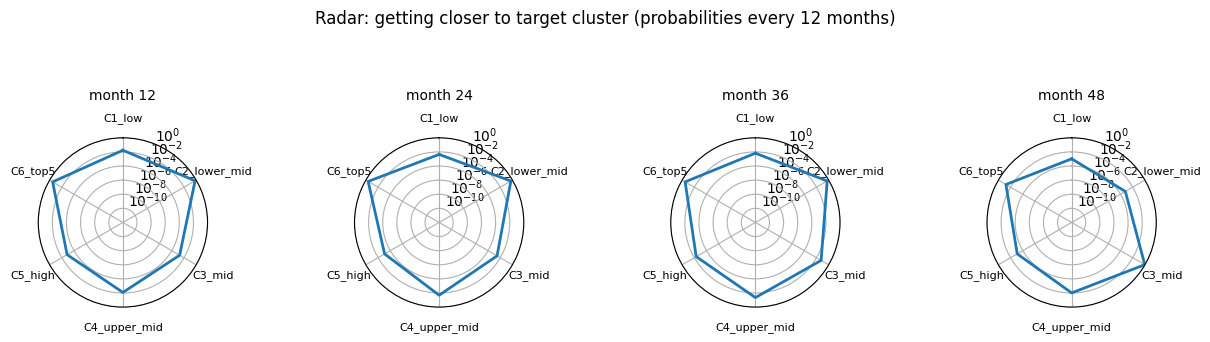

,checkpoint_month,pred_index,pred_name,top_prob_%,p_C1_low,p_C2_lower_mid,p_C3_mid,p_C4_upper_mid,p_C5_high,p_C6_top5
0,12,1,C2_lower_mid,65.617302,0.016998,0.656173,0.001939,0.008345,0.001364,0.315182
1,24,1,C2_lower_mid,54.925911,0.004427,0.549259,0.003006,0.020651,0.000851,0.421806
2,36,1,C2_lower_mid,56.918388,0.006582,0.569184,0.057086,0.044724,0.004905,0.317518
3,48,2,C3_mid,93.066597,0.001051,0.000619,0.930666,0.009741,0.000813,0.057110


In [15]:
RANDOM_SEED = 42

def lerp(a, b, t):
    return a + (b - a) * t

def random_budget_shares_biased(rng, mode="C1"):
    """
    Biased share generator for anchors.
    """
    s = {c: 0.0 for c in OUTFLOW_COLS}

    if mode == "C1":
        s["Housing"] = rng.uniform(0.35, 0.48)
        s["Utilities_Telecom"] = rng.uniform(0.06, 0.10)
        s["Groceries_FoodAtHome"] = rng.uniform(0.10, 0.16)

        s["Debt_Payments"] = rng.uniform(0.10, 0.20)
        s["Savings_Investments"] = rng.uniform(0.00, 0.03)

        s["Dining_FoodAway"] = rng.uniform(0.01, 0.05)
        s["Entertainment"] = rng.uniform(0.00, 0.02)
        s["Subscriptions_Memberships"] = rng.uniform(0.00, 0.01)
        s["Travel"] = rng.uniform(0.00, 0.01)

        for c in ["Transportation_Gas","Transportation_PublicTransit","Insurance_Health","Insurance_Auto","Medical_OutOfPocket","Pets","Education_Childcare"]:
            if c in s:
                s[c] = rng.uniform(0.00, 0.06)

        cap = rng.uniform(0.82, 0.92)

    elif mode == "C4":
        s["Housing"] = rng.uniform(0.22, 0.32)
        s["Utilities_Telecom"] = rng.uniform(0.04, 0.08)
        s["Groceries_FoodAtHome"] = rng.uniform(0.06, 0.11)

        s["Debt_Payments"] = rng.uniform(0.02, 0.10)
        s["Savings_Investments"] = rng.uniform(0.12, 0.25)

        s["Dining_FoodAway"] = rng.uniform(0.03, 0.08)
        s["Entertainment"] = rng.uniform(0.01, 0.04)
        s["Subscriptions_Memberships"] = rng.uniform(0.005, 0.02)
        s["Travel"] = rng.uniform(0.01, 0.06)

        for c in ["Transportation_Gas","Transportation_PublicTransit","Insurance_Health","Insurance_Auto","Medical_OutOfPocket","Pets","Education_Childcare"]:
            if c in s:
                s[c] = rng.uniform(0.00, 0.06)

        cap = rng.uniform(0.75, 0.88)
    else:
        raise ValueError(mode)

    total = sum(float(v) for v in s.values())
    if total > cap and total > 0:
        scale = cap / total
        for k in s:
            s[k] = float(s[k]) * scale

    for k in s:
        s[k] = max(0.0, float(s[k]))
    return s

def make_month_from_shares(income, shares):
    m = {INCOME_COL: float(income)}
    for c in OUTFLOW_COLS:
        m[c] = round(float(shares.get(c, 0.0)) * float(income), 2)
    return m

def simulate_person_months(income, mode, months=48, noise=0.10, seed=42):
    rng = np.random.default_rng(seed)
    out = []
    for _ in range(months):
        shares = random_budget_shares_biased(rng, mode=mode)

        # month-to-month variation so std features exist
        for c in OUTFLOW_COLS:
            shares[c] = max(0.0, float(shares.get(c, 0.0)) * float(rng.normal(1.0, noise)))

        # recap
        cap = 0.90 if mode == "C1" else 0.85
        total = sum(float(v) for v in shares.values())
        if total > cap and total > 0:
            scale = cap / total
            for k in shares:
                shares[k] = float(shares[k]) * scale

        inc = float(income) * float(rng.normal(1.0, 0.02))
        inc = max(1.0, inc)

        out.append(make_month_from_shares(inc, shares))
    return out

def find_anchor_for_cluster(target_idx, income, mode, max_tries=2500, seed=42):
    rng = np.random.default_rng(seed)
    best_months, best_proba = None, None
    best_target_p = -1.0

    # NOTE: leave=True so the bar doesn't instantly "disappear" (looks like it skipped)
    print(f"\nSearching anchor {mode}->{target_idx} (income={income}, max_tries={max_tries})")
    pbar = tqdm(range(max_tries), desc=f"Searching anchor {mode}->{target_idx}", leave=True, miniters=1)

    for k in pbar:
        months = simulate_person_months(income=income, mode=mode, months=48, noise=0.12, seed=int(seed + k))
        Xt = months_to_features(months)
        proba = model.predict_proba(Xt.values)[0]
        pred = int(np.argmax(proba))

        p_target = float(proba[target_idx])
        if p_target > best_target_p:
            best_target_p = p_target
            best_months, best_proba = months, proba

        # keep some live signal even if it finds the anchor quickly on k=0/1
        pbar.set_postfix({"pred": pred, "p_target": f"{p_target:.4f}", "best": f"{best_target_p:.4f}"})

        if pred == target_idx:
            pbar.close()
            print(f"[FOUND] {mode}->{target_idx} at try={k} | top_p={float(np.max(proba)):.4f} | p_target={p_target:.4f}")
            return months, proba

    pbar.close()
    print(f"[NOT FOUND] {mode}->{target_idx}. Returning best candidate with p_target={best_target_p:.4f}")
    return best_months, best_proba

def profile_from_months(months, eps=1e-12):
    income = np.array([float(m[INCOME_COL]) for m in months], dtype=np.float64)
    prof = {}
    for c in OUTFLOW_COLS:
        v = np.array([float(m.get(c, 0.0)) for m in months], dtype=np.float64)
        prof[c] = float(np.mean(v / np.maximum(income, eps)))
    return prof

def cap_and_fix_shares(shares, cap=0.86):
    s = dict(shares)
    for c in OUTFLOW_COLS:
        s[c] = max(0.0, float(s.get(c, 0.0)))
    total = sum(float(v) for v in s.values())
    if total > cap and total > 0:
        scale = cap / total
        for c in s:
            s[c] = float(s[c]) * scale
    return s

def what_if_transition(start_profile, target_profile, income_start, income_end, months=48, noise=0.06, seed=42):
    rng = np.random.default_rng(seed)
    out = []
    current = dict(start_profile)

    for i in range(months):
        t = i / (months - 1)
        income_t = lerp(float(income_start), float(income_end), t)

        # heuristic: gradually move shares towards target profile
        alpha = 0.10 + 0.55 * t
        proposed = {}
        for c in OUTFLOW_COLS:
            proposed[c] = lerp(float(current.get(c, 0.0)), float(target_profile.get(c, 0.0)), alpha)

        # nudges (policy)
        proposed["Savings_Investments"] = proposed.get("Savings_Investments", 0.0) + 0.05 * t
        proposed["Debt_Payments"] = max(0.0, proposed.get("Debt_Payments", 0.0) * (1.0 - 0.55 * t))

        # keep essentials not collapsing
        proposed["Housing"] = max(proposed.get("Housing", 0.0), 0.18)
        proposed["Groceries_FoodAtHome"] = max(proposed.get("Groceries_FoodAtHome", 0.0), 0.06)
        proposed["Utilities_Telecom"] = max(proposed.get("Utilities_Telecom", 0.0), 0.03)

        proposed = cap_and_fix_shares(proposed, cap=0.86)

        # month noise (std features)
        noisy = {}
        for c in OUTFLOW_COLS:
            noisy[c] = max(0.0, float(proposed.get(c, 0.0)) * float(rng.normal(1.0, noise)))
        noisy = cap_and_fix_shares(noisy, cap=0.86)

        current = noisy
        out.append(make_month_from_shares(income_t, noisy))

    return out

def radar_probs_checkpoints(months, checkpoints=(12,24,36,48), title="Radar: cluster probabilities at checkpoints"):
    labels = [CLUSTER_META[i]["name"] for i in range(6)]
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    eps = 1e-12

    # 4 radars in one row, slightly smaller height to reduce title overlap
    fig, axes = plt.subplots(1, len(checkpoints), figsize=(3.2*len(checkpoints), 3.0), subplot_kw={"polar": True})
    if len(checkpoints) == 1:
        axes = [axes]

    rows = []
    for ax, t in zip(axes, checkpoints):
        Xt = months_to_features(months[:t])
        proba = model.predict_proba(Xt.values)[0]
        pred = int(np.argmax(proba))

        vals = [max(eps, float(v)) for v in proba.tolist()]
        vals += vals[:1]

        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=8)

        # log scaling so tiny probabilities are visible
        ax.set_rscale("log")
        ax.set_rlim(eps, 1.0)

        ax.plot(angles, vals, linewidth=2)
        ax.set_title(f"month {t}", y=1.18, fontsize=10)

        row = {
            "checkpoint_month": t,
            "pred_index": pred,
            "pred_name": CLUSTER_META[pred]["name"],
            "top_prob_%": float(np.max(proba) * 100.0),
        }
        row.update(proba_dict(proba))
        rows.append(row)

    print("\nPlot — Radar chart (probabilities every 12 months):\n")
    fig.suptitle(title, y=1.10)
    plt.tight_layout()
    plt.show()

    display(pd.DataFrame(rows))

# ---- anchors + what-if transition ----
TARGET_C1 = 0
TARGET_C4 = 3

anchor_c1_months, p_c1 = find_anchor_for_cluster(TARGET_C1, income=2200, mode="C1", seed=RANDOM_SEED)
anchor_c4_months, p_c4 = find_anchor_for_cluster(TARGET_C4, income=9000, mode="C4", seed=RANDOM_SEED + 1)

if anchor_c1_months is None or anchor_c4_months is None:
    raise RuntimeError("Could not find anchors fast enough. Increase max_tries or loosen ranges in random_budget_shares_biased().")

start_profile = profile_from_months(anchor_c1_months)
target_profile = profile_from_months(anchor_c4_months)

print("\nExpectation:\n")
print(f"Expected (intent): start={CLUSTER_META[TARGET_C1]['name']} -> target={CLUSTER_META[TARGET_C4]['name']}")
print(f"Expected by income (month 1):  {CLUSTER_META[expected_cluster_by_income(2200.0)]['name']}")
print(f"Expected by income (month 48): {CLUSTER_META[expected_cluster_by_income(9000.0)]['name']}")

print("\nAnchors found (single-month view for month 1 of each anchor):\n")
pretty_predict_one_month(anchor_c1_months[0])
pretty_predict_one_month(anchor_c4_months[0])

months_48 = what_if_transition(
    start_profile=start_profile,
    target_profile=target_profile,
    income_start=2200,
    income_end=9000,
    months=48,
    noise=0.06,
    seed=RANDOM_SEED
)

# ---------- Table 0 ($ amounts) + Table 0b (Δ$) ----------
df_dollars = pd.DataFrame(months_48)
df_dollars.insert(0, "month", np.arange(1, len(df_dollars) + 1))

df_delta = df_dollars.copy()
for c in [INCOME_COL] + OUTFLOW_COLS:
    df_delta[c] = df_dollars[c].diff().fillna(0.0)

print("\nTable 0 — Dollar amounts per month (all categories):\n")
display(df_dollars)

print("\nTable 0b — Dollar change per month (Δ$ for all categories):\n")
display(df_delta)

# ---------- Table 1 (single-month prediction + rates) ----------
rows = []
for i, m in enumerate(tqdm(months_48, desc="Single-month predictions", leave=False), 1):
    pred1, proba1 = pretty_predict_one_month(m)
    rates = month_rates(m)
    row = {
        "month": i,
        "Income": rates["Income"],
        "SavingsRate": rates["SavingsRate"],
        "NetCashflowRate": rates["NetCashflowRate"],
        "pred_single_month": CLUSTER_META[pred1]["name"],
        "top_prob_%": float(np.max(proba1) * 100),
    }
    row.update(proba_dict(proba1))
    rows.append(row)

print("\nTable 1 — Single-month prediction + rates:\n")
display(pd.DataFrame(rows))

# ---------- Trajectory (cumulative months) + log prob plot ----------
run_trajectory(months_48, title="48-month transition: what-if heuristic C1 -> C4")

# ---------- Radar checkpoints ----------
radar_probs_checkpoints(
    months_48,
    checkpoints=(12,24,36,48),
    title="Radar: getting closer to target cluster (probabilities every 12 months)"
)